# D Parameter Sweep Analysis

analyze how projection dimension d affects model performance and stability


In [1]:
import sys
sys.path.append('..')

import numpy as np
import torch
import matplotlib.pyplot as plt
from src.experiments import run_sweep_d_agg, run_sweep_d_multiple_seeds, repeat_spherical_runs_for_d
from src.training import run_exact
from src.config import TrainCfg
from src.kernels import SM_kernel, stable_matern_kernel, stable_rbf_kernel, long_periodic_plus_short_rbf
from src.utils import plot_posteriors_auto
from src.data_generation import (
    generate_oscillatory_data,
    generate_piecewise_data,
    generate_piecewise_linear_data
)


## Run Exact GP Baseline


In [3]:
# train once for baseline lines
x_train, y_train, x_test, y_test, x_plot = generate_oscillatory_data(N=1000)

res_exact = run_exact(
    x_train, y_train, x_test, y_test,
    kernel=SM_kernel(1, 1, y_std=float(torch.std(y_train))),
    cfg=TrainCfg(verbose=False),
    init_from_data=False
)

print(f"exact GP baseline - RMSE: {res_exact['metrics']['RMSE']:.4f}, R2: {res_exact['metrics']['R2']:.4f}")


exact GP baseline - RMSE: 0.0982, R2: 0.9999


## Sweep Over D Values


Sweeping d values:  14%|█▍        | 1/7 [00:11<01:06, 11.00s/it]


=== Summary of 20 runs ===
Base seed: 0
Projection dimension: 15
Number of mixtures: 1
Multi-scale: False
Exact GP included: False
SVGP included: False

=== Metrics Summary ===
spherical_RMSE: 1.9394 ± 3.0886
spherical_NLPD: 38.8361 ± 91.6908
spherical_COV95: 79.6500 ± 38.3405
spherical_time: 0.5389 ± 0.2507


Sweeping d values:  29%|██▊       | 2/7 [00:19<00:49,  9.81s/it]


=== Summary of 20 runs ===
Base seed: 10000
Projection dimension: 30
Number of mixtures: 1
Multi-scale: False
Exact GP included: False
SVGP included: False

=== Metrics Summary ===
spherical_RMSE: 0.9086 ± 2.3003
spherical_NLPD: 13.1134 ± 57.0815
spherical_COV95: 94.7667 ± 20.6514
spherical_time: 0.4383 ± 0.1540


Sweeping d values:  43%|████▎     | 3/7 [00:33<00:46, 11.55s/it]


=== Summary of 20 runs ===
Base seed: 20000
Projection dimension: 50
Number of mixtures: 1
Multi-scale: False
Exact GP included: False
SVGP included: False

=== Metrics Summary ===
spherical_RMSE: 0.8122 ± 1.0924
spherical_NLPD: 0.6878 ± 0.7136
spherical_COV95: 97.8000 ± 4.2349
spherical_time: 0.6678 ± 0.3270


Sweeping d values:  57%|█████▋    | 4/7 [00:47<00:37, 12.40s/it]


=== Summary of 20 runs ===
Base seed: 30000
Projection dimension: 100
Number of mixtures: 1
Multi-scale: False
Exact GP included: False
SVGP included: False

=== Metrics Summary ===
spherical_RMSE: 0.5815 ± 0.6523
spherical_NLPD: 0.8113 ± 1.4045
spherical_COV95: 96.2333 ± 13.3562
spherical_time: 0.6743 ± 0.2368


Sweeping d values:  71%|███████▏  | 5/7 [01:02<00:26, 13.39s/it]


=== Summary of 20 runs ===
Base seed: 40000
Projection dimension: 200
Number of mixtures: 1
Multi-scale: False
Exact GP included: False
SVGP included: False

=== Metrics Summary ===
spherical_RMSE: 0.2691 ± 0.1729
spherical_NLPD: 0.4588 ± 0.1738
spherical_COV95: 100.0000 ± 0.0000
spherical_time: 0.7452 ± 0.3634


Sweeping d values:  86%|████████▌ | 6/7 [01:19<00:14, 14.63s/it]


=== Summary of 20 runs ===
Base seed: 50000
Projection dimension: 300
Number of mixtures: 1
Multi-scale: False
Exact GP included: False
SVGP included: False

=== Metrics Summary ===
spherical_RMSE: 0.3702 ± 0.5064
spherical_NLPD: 0.4763 ± 0.3014
spherical_COV95: 99.6500 ± 1.1418
spherical_time: 0.8403 ± 0.3930


Sweeping d values: 100%|██████████| 7/7 [01:47<00:00, 15.29s/it]



=== Summary of 20 runs ===
Base seed: 60000
Projection dimension: 500
Number of mixtures: 1
Multi-scale: False
Exact GP included: False
SVGP included: False

=== Metrics Summary ===
spherical_RMSE: 0.2056 ± 0.1356
spherical_NLPD: 0.4647 ± 0.1619
spherical_COV95: 100.0000 ± 0.0000
spherical_time: 1.3634 ± 0.6851

Results averaged over 20 seeds:
     RMSE_mean  RMSE_std  COV95_mean  COV95_std  NLPD_mean   NLPD_std  \
d                                                                       
15    1.939443  3.088604   79.650000  38.340499  38.836105  91.690848   
30    0.908648  2.300267   94.766667  20.651409  13.113387  57.081484   
50    0.812227  1.092361   97.800000   4.234915   0.687778   0.713606   
100   0.581538  0.652251   96.233333  13.356165   0.811296   1.404493   
200   0.269076  0.172862  100.000000   0.000000   0.458804   0.173839   
300   0.370214  0.506422   99.650000   1.141841   0.476325   0.301371   
500   0.205597  0.135590  100.000000   0.000000   0.464667   0.161933

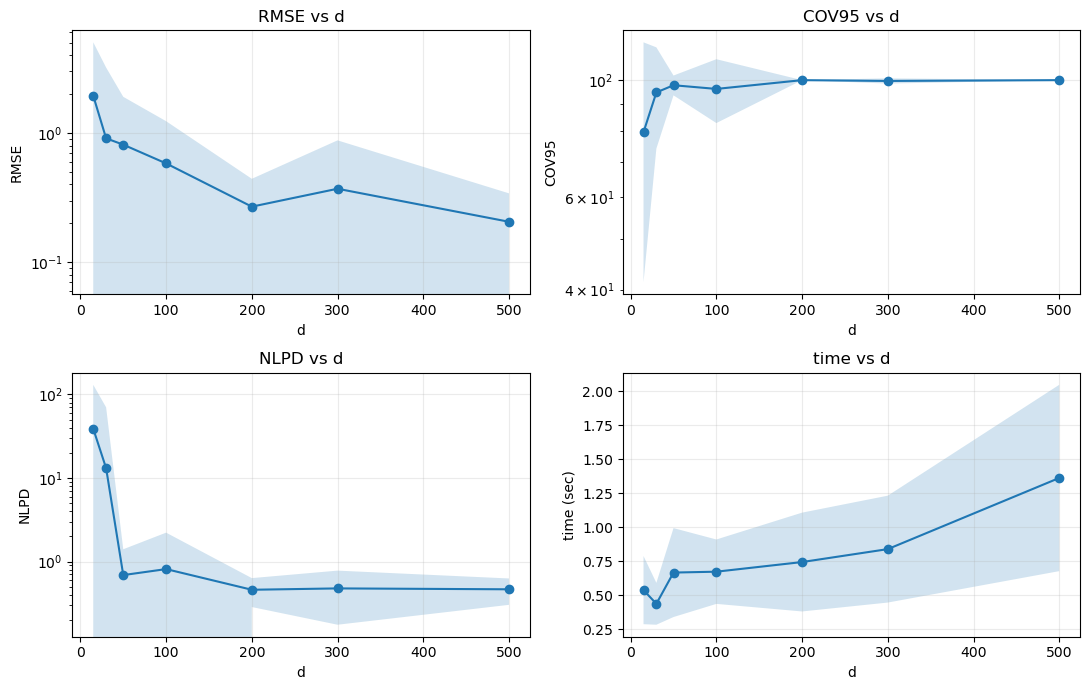


best d=500 (RMSE=0.2056+/-0.1356, COV95=100.0000+/-0.0000, NLPD=0.4647+/-0.1619, time=1.36+/-0.69s)


In [ ]:
# sweep and aggregate
x_train, y_train, x_test, y_test, x_plot = generate_oscillatory_data(N=1000)
d_list = [15, 30, 50, 100, 200, 300, 500]
df_agg, reps_for_best, runs_raw = run_sweep_d_multiple_seeds(
    x_train, y_train, x_test, y_test,
    d_list=d_list,
    n_seeds=20,
    num_mixtures=1,
    cfg=TrainCfg(max_iter=500, patience=40, lr=0.05, verbose=False),
    init_hyps_data=False,
    savepath='../results/d_sweep_metrics.png'
)


## Visualise Best D


best d: 300


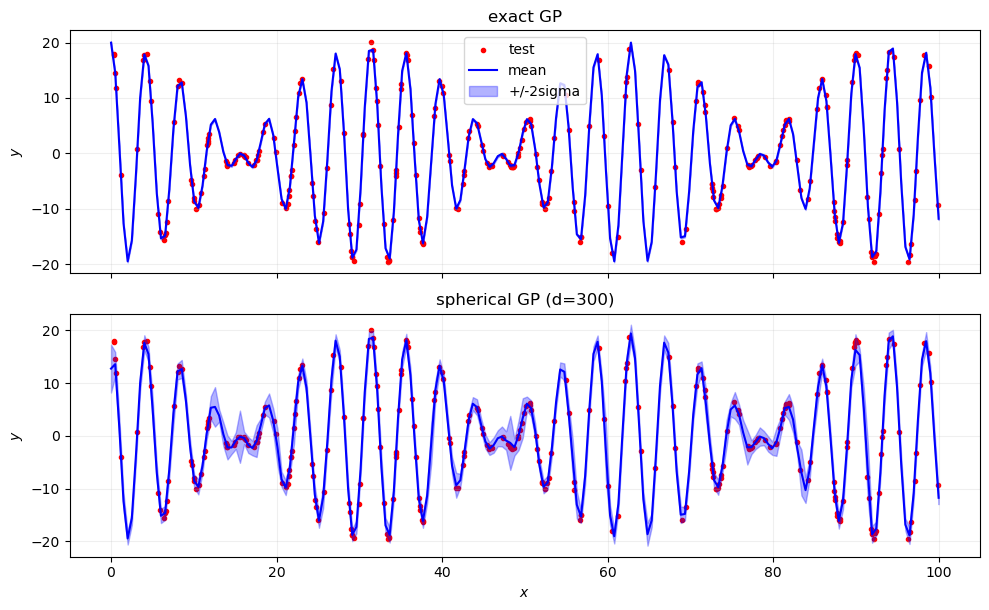

In [6]:
# visualise posterior for the best d using one representative run
best_d = int(df_agg['RMSE_mean'].idxmin())
print(f"best d: {best_d}")

from src.training import predict_svgp

_ = plot_posteriors_auto(
    D=x_train.shape[1],
    res_exact=res_exact,
    res_proj=reps_for_best[best_d],  # first repeat at best d
    res_svgp=None,
    x_test=x_test, y_test=y_test, x_plot=x_plot,
    d_proj=best_d,
    predict_svgp_fn=predict_svgp,
    plot1d_fn=None,
    add_svgp_heatmap=False,
    savepath=None
)


## Hyperparameter Variability Analysis


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:31<00:00,  1.06s/it]


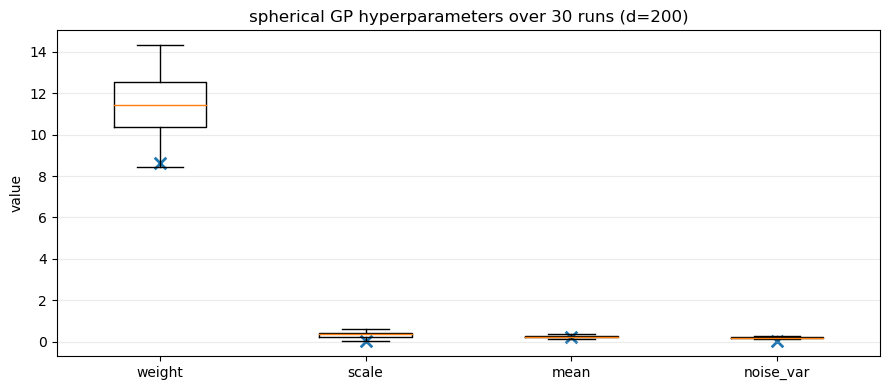

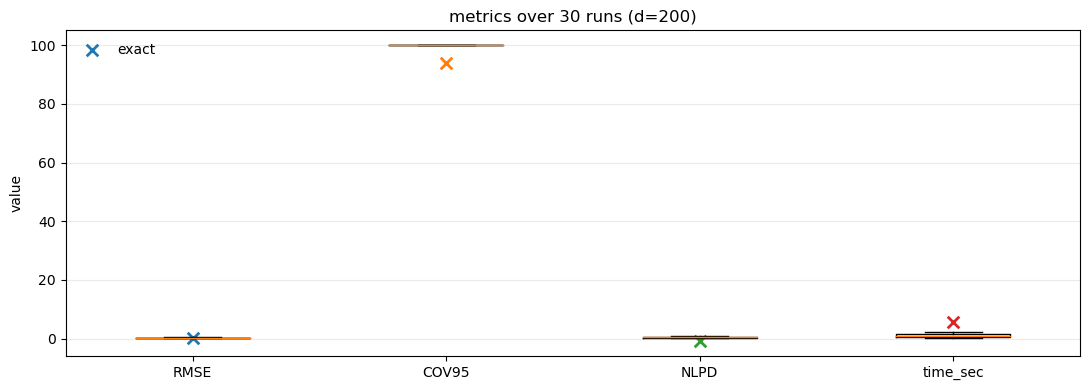

In [4]:
# analyse hyperparameter stability for a fixed d
x_train, y_train, x_test, y_test, x_plot = generate_oscillatory_data(N=1000)

df_hyp, df_metric, reps = repeat_spherical_runs_for_d(
    x_train, y_train, x_test, y_test,
    d=200,
    k=30,
    num_mixtures=1,
    cfg=TrainCfg(max_iter=500, patience=40, lr=0.05, verbose=False),
    init_hyps_data=False,
    res_exact=res_exact,
    savepath_hyp='../results/hyp_box_d200.png',
    savepath_nlpd='../results/nlpd_box_d200.png'
)
